# Test raw model values
- loads tas and pr datasets from historical CMIP6 model output files
- plots raw tas and pr values and climatology to test that no models have any issues

In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????

In [2]:
# dask allows you to check how long something is taking to load
import dask.diagnostics

In [3]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [4]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print(models.model.data)

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CIESM' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5'
 'CanESM5' 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


In [11]:
# just renaming datasets so it's consistent with scott's notebook so I don't have to change the names and make mistakes
ds = models
pr = ds.pr
tas = ds.tas

In [12]:
# select out the asutralia region since it's our region of interest
pr_Aus = pr.sel(lat=slice(-50,-10), lon=slice(110,160)).sel(time=slice('18780801','18880831'))
tas_Aus = tas.sel(lat=slice(-50,-10), lon=slice(110,160)).sel(time=slice('18780801','18880831'))

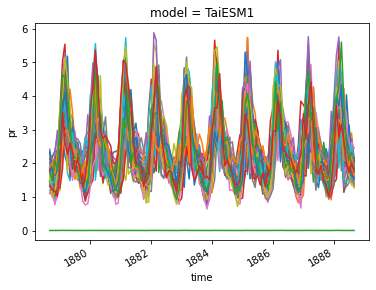

In [13]:
# check the raw pr values from the models by plotting all models
# note pr has a large range between models in the peak rainfall each season 
for i in range(pr_Aus.sizes['model']):
    pr_Aus.isel(model=i).mean(['lat','lon']).plot(label=i)
    
#plt.legend()

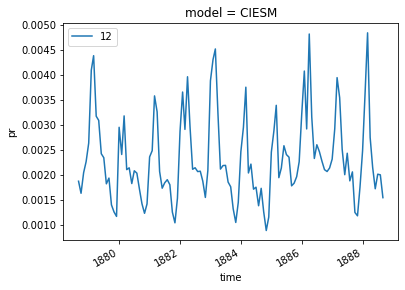

In [14]:
# finding the graph that appears to be 0 or at least too low 
pr_Aus.isel(model=12).mean(['lat','lon']).plot(label='12')
plt.legend()

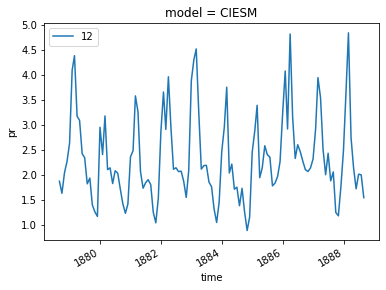

In [15]:
# now i've found the model is CIESM and it's not 0, but rather appears to be out by a factor of 1000
CIESM = pr_Aus.isel(model=12).mean(['lat','lon'])
times_1000 = CIESM*1000
times_1000.plot(label='12')
plt.legend()

In [16]:

with dask.diagnostics.ProgressBar():
    pr_climatology = pr.sel(time=slice('18500101','18801231')).groupby('time.month').mean().load()

[########################################] | 100% Completed | 50.6s


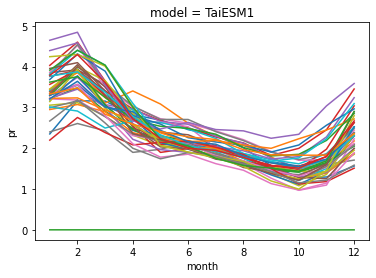

In [17]:
for i in range(pr_Aus.sizes['model']):
    pr_climatology.sel(lat=slice(-50,-10), lon=slice(110,160)).isel(model=i).mean(['lat','lon']).plot()

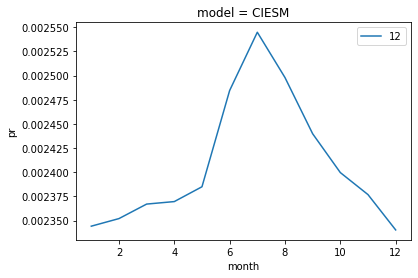

In [18]:
# plot the model CIESM that appears to be too low 
pr_climatology.isel(model=12).mean(['lat','lon']).plot(label='12')
plt.legend()

In [19]:
# eliminate odd models and plot again to make sure everthing looks ok
pr_Aus = pr_Aus.drop_sel(model=['CIESM'])

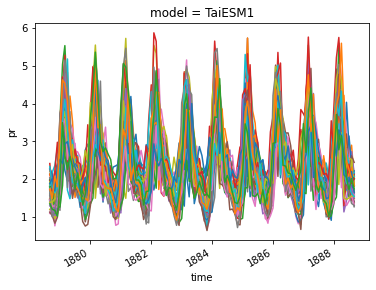

In [20]:
# check the raw pr values from the models by plotting all models
# note pr has a large range between models in the peak rainfall each season 
for i in range(pr_Aus.sizes['model']):
    pr_Aus.isel(model=i).mean(['lat','lon']).plot(label=i)
    

# Temperature

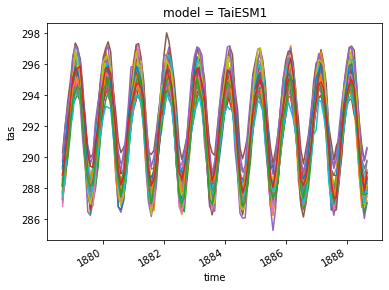

In [21]:
# plot the raw temperature values for each model 
for i in range(tas_Aus.sizes['model']):
    tas_Aus.isel(model=i).mean(['lat','lon']).plot()

In [22]:
# define climatology and so I can test that it's fine too 
tas_climatology = tas.sel(time=slice('18500101','18801231')).groupby('time.month').mean()

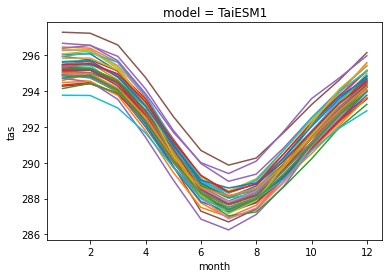

In [23]:
# plot the climatology for temperature and ensure that no models have issues
for i in range(tas_Aus.sizes['model']):
    tas_climatology.sel(lat=slice(-50,-10), lon=slice(110,160)).isel(model=i).mean(['lat','lon']).plot()